In [1]:
import h5py

# 打开MAT文件并列出所有数据集
with h5py.File('training_data.mat', 'r') as f:
    # 列出所有的keys，即数据集名称
    def print_structure(name):
        print(name)
    
    f.visit(print_structure)


psi_imag_data
psi_real_data
vx_data
vy_data
vz_data


In [2]:
import h5py
import torch


In [3]:
# 标准化后的数据检查函数
def check_data_after_normalization(data, data_name="data"):
    if torch.isnan(data).any():
        print(f"{data_name} contains NaN values after normalization")
    if torch.isinf(data).any():
        print(f"{data_name} contains infinite values after normalization")


In [4]:
import h5py
import torch

# 使用 h5py 打开并读取数据
with h5py.File('training_data.mat', 'r') as f:
    # 读取每个数据集
    vx_data = torch.tensor(f['vx_data'][:], dtype=torch.float32)
    vy_data = torch.tensor(f['vy_data'][:], dtype=torch.float32)
    vz_data = torch.tensor(f['vx_data'][:], dtype=torch.float32)
    psi_real_data = torch.tensor(f['psi_real_data'][:], dtype=torch.float32)
    psi_imag_data = torch.tensor(f['psi_imag_data'][:], dtype=torch.float32)

# 检查数据的形状
print(f'vx_data shape: {vx_data.shape}')
print(f'vy_data shape: {vy_data.shape}')
print(f'vz_data shape: {vz_data.shape}')
print(f'psi_real_data shape: {psi_real_data.shape}')
print(f'psi_imag_data shape: {psi_imag_data.shape}')





vx_data shape: torch.Size([2001, 64, 64, 64])
vy_data shape: torch.Size([2001, 64, 64, 64])
vz_data shape: torch.Size([2001, 64, 64, 64])
psi_real_data shape: torch.Size([2001, 4, 64, 64, 64])
psi_imag_data shape: torch.Size([2001, 4, 64, 64, 64])


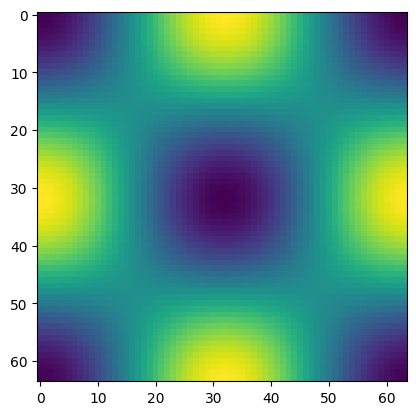

In [5]:
import matplotlib.pyplot as plt
plt.imshow(vx_data[1000,:,:,32])

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# 数据标准化函数
def normalize_data(data):
    mean = data.mean()
    std = data.std()
    return (data - mean) / std

# 自定义数据集类
class WaveFunctionDataset(Dataset):
    def __init__(self, vx, vy, vz, psi_real, psi_imag):
        self.vx = normalize_data(vx)
        self.vy = normalize_data(vy)
        self.vz = normalize_data(vz)
        self.psi_real = psi_real
        self.psi_imag = psi_imag

    def __len__(self):
        return len(self.vx)

    def __getitem__(self, idx):
        vx = self.vx[idx]
        vy = self.vy[idx]
        vz = self.vz[idx]
        psi_real = self.psi_real[idx]
        psi_imag = self.psi_imag[idx]
        return {'vx': vx, 'vy': vy, 'vz': vz, 'psi_real': psi_real, 'psi_imag': psi_imag}


In [7]:
# 标准化并检查数据
vx_norm = normalize_data(vx_data)
vy_norm = normalize_data(vy_data)
vz_norm = normalize_data(vz_data)
check_data_after_normalization(vx_norm, "vx_data")
check_data_after_normalization(vy_norm, "vy_data")
check_data_after_normalization(vz_norm, "vz_data")

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 减少卷积层通道数
        self.conv1 = nn.Conv3d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        
        self.pool = nn.AdaptiveAvgPool3d((8, 8, 8))
        self.fc1 = nn.Linear(64 * 8 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 4 * 2 * 64 * 64 * 64)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x.view(-1, 4, 2, 64, 64, 64)


In [9]:
# 初始化模型和其他组件
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
criterion = nn.MSELoss()  # 损失函数为均方误差
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # 使用较低的学习率

In [10]:
device

device(type='cuda')

In [11]:
# 使用一部分数据进行实验
num_samples = 100  # 选择100个样本进行试验
dataset = WaveFunctionDataset(vx_data[:num_samples], vy_data[:num_samples], vz_data[:num_samples],
                              psi_real_data[:num_samples], psi_imag_data[:num_samples])
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


In [12]:
# 训练模型
epochs = 5  # 训练轮数

scaler = torch.cuda.amp.GradScaler()  # 创建混合精度缩放器



In [13]:
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for batch in dataloader:
        vx = batch['vx'].unsqueeze(1).to(device)
        vy = batch['vy'].unsqueeze(1).to(device)
        vz = batch['vz'].unsqueeze(1).to(device)
        psi_real = batch['psi_real'].to(device)
        psi_imag = batch['psi_imag'].to(device)
        
        inputs = torch.cat([vx, vy, vz], dim=1)
        optimizer.zero_grad()
        
        # 前向传播与损失计算，使用混合精度
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            psi_real_pred = outputs[:, :, 0, :, :, :]
            psi_imag_pred = outputs[:, :, 1, :, :, :]
            
            # 在计算损失之前检查预测值和目标值
            if torch.isnan(psi_real_pred).any() or torch.isnan(psi_imag_pred).any():
                print("NaN detected in predictions!")
            if torch.isnan(psi_real).any() or torch.isnan(psi_imag).any():
                print("NaN detected in target values!")

            loss_real = criterion(psi_real_pred, psi_real)
            loss_imag = criterion(psi_imag_pred, psi_imag)
            loss = loss_real + loss_imag
        
        # 反向传播和优化
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}')


Epoch 1/5, Loss: 0.003633
Epoch 2/5, Loss: 0.003219
Epoch 3/5, Loss: 0.002924
Epoch 4/5, Loss: 0.002710
Epoch 5/5, Loss: 0.002574


In [37]:
import matplotlib.pyplot as plt

# 选择一个样本索引进行可视化
sample_idx = 0

# 获取数据
sample = dataset[sample_idx]
vx = sample['vx'].unsqueeze(0).unsqueeze(0).to(device)
vy = sample['vy'].unsqueeze(0).unsqueeze(0).to(device)
vz = sample['vz'].unsqueeze(0).unsqueeze(0).to(device)
psi_real_true = sample['psi_real'].cpu().numpy()
psi_imag_true = sample['psi_imag'].cpu().numpy()

inputs = torch.cat([vx, vy, vz], dim=1)

# 获取模型预测
model.eval()
with torch.no_grad():
    outputs = model(inputs)
    psi_real_pred = outputs[:, :, 0, :, :, :].cpu().numpy()
    psi_imag_pred = outputs[:, :, 1, :, :, :].cpu().numpy()



In [40]:
psi_real_pred.shape, psi_imag_pred.shape, psi_real_true.shape, psi_imag_true.shape

((1, 4, 64, 64, 64), (1, 4, 64, 64, 64), (4, 64, 64, 64), (4, 64, 64, 64))

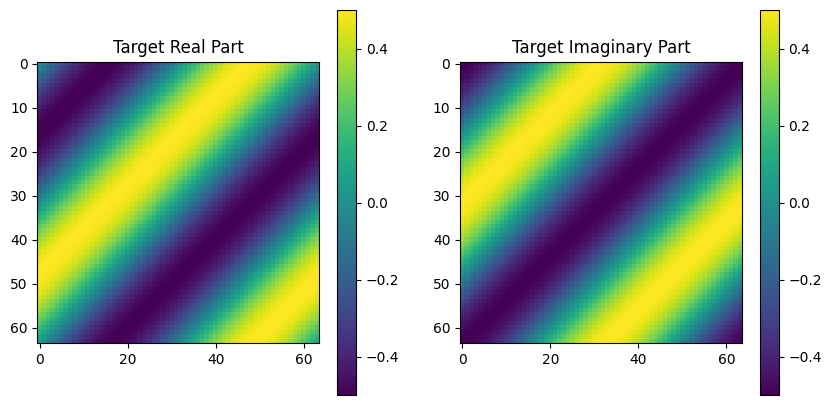

In [41]:
# 可视化真实值和预测值
def plot_wavefunction(real, imag, title):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(real[ 0, :, :, 32], cmap='viridis')
    plt.title(f'{title} Real Part')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(imag[ 0, :, :, 32], cmap='viridis')
    plt.title(f'{title} Imaginary Part')
    plt.colorbar()

    plt.show()

# 可视化目标值
plot_wavefunction(psi_real_true, psi_imag_true, 'Target')




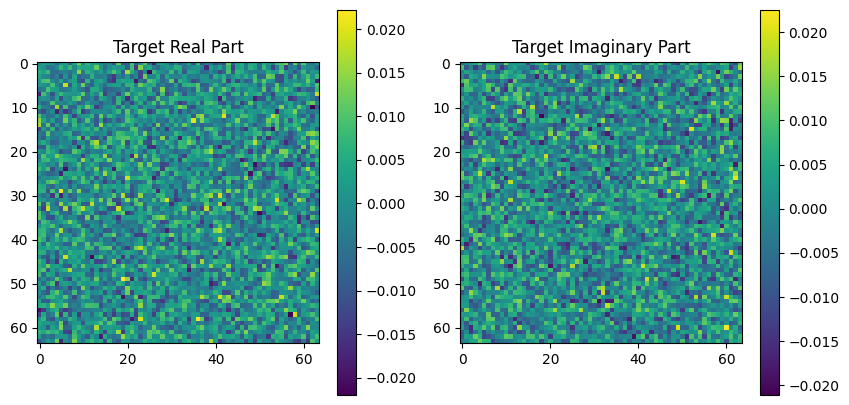

In [42]:
def plot_wavefunction(real, imag, title):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(real[0, 0, :, :, 32], cmap='viridis')
    plt.title(f'{title} Real Part')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(imag[ 0,0, :, :, 32], cmap='viridis')
    plt.title(f'{title} Imaginary Part')
    plt.colorbar()

    plt.show()

# 可视化目标值
plot_wavefunction(psi_real_pred, psi_imag_pred, 'Target')

# plt.imshow(psi_imag_true[0, :, :,32])

In [45]:
import scipy.io as sio
import numpy as np

# 假设 psi_real_pred 和 psi_imag_pred 已经是 NumPy 数组
# 如果它们已经是 NumPy 数组，你可以跳过转换
psi_real_pred_np = np.squeeze(psi_real_pred[0,:,:,:,:])
psi_imag_pred_np = np.squeeze(psi_imag_pred[0,:,:,:,:])

# 创建一个 4D 复数数组，将实部和虚部结合
psi_complex = psi_real_pred_np + 1j * psi_imag_pred_np

# 保存为 .mat 文件
sio.savemat('psi_pred.mat', {'psi': psi_complex})


In [46]:
psi_real_pred[0,:,:,:,:].shape

(4, 64, 64, 64)

In [47]:
import scipy.io as sio
import numpy as np

# 假设 psi_real_pred 和 psi_imag_pred 已经是 NumPy 数组
# 并且它们的形状是 (4, 64, 64, 64)
psi_real_pred_np = np.transpose(psi_real_pred[0, :, :, :, :], (1, 2, 3, 0))
psi_imag_pred_np = np.transpose(psi_imag_pred[0, :, :, :, :], (1, 2, 3, 0))

# 创建一个 4D 复数数组，将实部和虚部结合
psi_complex = psi_real_pred_np + 1j * psi_imag_pred_np

# 检查转换后的形状，应该是 (64, 64, 64, 4)
print(psi_complex.shape)

# 保存为 .mat 文件
sio.savemat('psi_pred.mat', {'psi': psi_complex})


(64, 64, 64, 4)
